In [1448]:

import numpy as np
import math
import pandas as pd
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import jpholiday
import pickle
from ydata_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')


# pandasの表示を設定
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 300

In [1449]:
train = pd.read_csv('train.csv', encoding='utf-8')
search_specified = pd.read_csv('search_specified.csv', encoding='utf-8')
search_unspecified = pd.read_csv('search_unspecified.csv', encoding='utf-8')
road = pd.read_csv('road_local.csv', encoding='utf-8')

### テーブルのマージと特徴量の追加

In [1450]:
# day_of_week, day_of_year, holiday, tomorrow_holiday, yesterday_holidayを追加
def is_holiday(date):
    
    return (date.weekday() >= 5) or jpholiday.is_holiday(date)


def set_flags(df):
    
    df['tomorrow'] = df['date'] + pd.to_timedelta(1, 'd')
    #df['yesterday'] = df['date'] - pd.to_timedelta(1, 'd')
    df['day_of_week'] = df['date'].dt.weekday
    
    holidays = df['date'].apply(jpholiday.is_holiday)

    df['holiday'] = ((df['day_of_week'] >= 5) | holidays).astype(int)
    df['tomorrow_holiday'] = ((df['tomorrow'].dt.weekday >= 5) | holidays.shift(-1)).astype(int)
    #df['yesterday_holiday'] = ((df['yesterday'].dt.weekday >= 5) | holidays.shift(1)).astype(int)
    
    df = df.drop(['tomorrow'], axis=1)
    
    return df

search_unspecified['date'] = pd.to_datetime(search_unspecified['date'])

search_unspecified = set_flags(search_unspecified)

search_unspecified['day_of_year'] = search_unspecified['date'].dt.dayofyear

In [1451]:

# datetime, dateをyear, month, day, hourに展開
# テーブルをマージ
# 不要なカラムを削除
def expand_datetime(df):
    if 'date' in df.columns:
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
    if 'datetime' in df.columns:
        df['year'] = df['datetime'].dt.year
        df['month'] = df['datetime'].dt.month
        df['day'] = df['datetime'].dt.day
        df['hour'] = df['datetime'].dt.hour
    return df

train['datetime'] = pd.to_datetime(train['datetime'])
train['date'] = train['datetime'].dt.date
train['date'] = pd.to_datetime(train['date'])
search_specified['datetime'] = pd.to_datetime(search_specified['datetime'])
search_unspecified['date'] = pd.to_datetime(search_unspecified['date'])
search_specified['datetime'] -= pd.to_timedelta(1, 'd')
search_unspecified['date'] -= pd.to_timedelta(1, 'd')

train = expand_datetime(train)

train_merged = train.merge(search_specified, on=['datetime', 'start_code', 'end_code'], how='left')

train_merged = train_merged.merge(search_unspecified, on=['date', 'start_code', 'end_code'], how='left')

train_merged = train_merged.merge(road.drop(['start_name', 'end_name', 'start_KP', 'end_KP', 'start_pref_code', 'end_pref_code', 'start_lat', 'end_lat', 'start_lng', 'end_lng', 'start_degree', 'end_degree', 'direction', 'road_code'], axis=1), on=['start_code', 'end_code'], how='left')

In [1452]:
# 連休何日目か(n_of_holidays)を追加
mask = train_merged['holiday'] != train_merged['holiday'].shift(1).fillna(0)
train_merged['n_of_holidays'] = train_merged.groupby(mask.cumsum()).cumcount() + 1
train_merged.loc[train_merged['holiday'] == 0, 'n_of_holidays'] = 0

In [1453]:
# section(始点IC-KP-終点IC)を追加しラベルエンコード
train_merged['section'] = train_merged['start_code'].astype(str) + '_' + train_merged['KP'].astype(str) + '_' + train_merged['end_code'].astype(str)

label_encoder = LabelEncoder()
train_merged['section'] = label_encoder.fit_transform(train_merged['section'])

with open('label.pickle', 'wb') as le:
    pickle.dump(label_encoder, le)


In [1454]:
# 目的変数として翌日同時刻のis_congestion(is_congestion_tomorrow)を追加
sub_df = train_merged[['datetime', 'section', 'is_congestion']].rename(columns={'is_congestion':'is_congestion_tomorrow'})
sub_df['datetime'] -= pd.to_timedelta(1, 'd')
train_merged = pd.merge(train_merged, sub_df, on=['datetime', 'section'], how='left')
train_merged = train_merged.loc[train_merged['is_congestion_tomorrow'].notnull()]
    

In [1455]:
# hour, day_of_yearをsin, cos変換

def sin_cos_encoder(data, cols):

    for col in cols:
        data[f'{col}_sin'] = np.sin(2 * np.pi * data[col]/data[col].max())
        data[f'{col}_cos'] = np.cos(2 * np.pi * data[col]/data[col].max())

    return data


train_merged = sin_cos_encoder(train_merged, ['month', 'day', 'hour', 'day_of_year'])

In [1456]:
# search_specifiedの同時刻同区間平均(search_specified_hour_mean)を追加
train_merged['search_specified_hour_mean'] = train_merged.groupby(['hour', 'section'])['search_specified'].transform('mean')

## 同区間同曜日同時刻のsearch_specifiedの平均
#train_merged['search_specified_same_dow_hour_mean'] = train_merged.groupby(['hour', 'day_of_week', 'section'])['search_specified'].transform('mean') 

# search_specifiedの同区間同日同時刻平均(search_specified_same_day_hour_mean)を追加
train_merged['search_specified_same_day_hour_mean'] = train_merged.groupby(['month', 'day', 'hour', 'section'])['search_specified'].transform('mean')    
train_merged['search_specified'].fillna(train_merged['search_specified_same_day_hour_mean'], inplace=True)

In [1457]:
# search_unspecifiedの同区間平均(search_unspecified_mean)を追加
train_merged['search_unspecified_mean'] = train_merged.groupby(['section'])['search_unspecified'].transform('mean')

## 同区間同曜日のsearch_unspecifiedの平均
#train_merged['search_unspecified_same_dow_mean'] = train_merged.groupby(['day_of_week', 'section'])['search_unspecified'].transform('mean') 

# search_unspecifiedの同区間同日平均(search_unspecified_same_day_mean)を追加
train_merged['search_unspecified_same_day_mean'] = train_merged.groupby(['month','day', 'section'])['search_unspecified'].transform('mean')
train_merged['search_unspecified'].fillna(train_merged['search_unspecified_same_day_mean'], inplace=True)

In [1458]:
# 同区間のis_congestionの平均
train_merged['congestion_mean'] = train_merged.groupby(['section'])['is_congestion'].transform('mean')

# 同区間同時刻のis_congestionの平均
train_merged['congestion_hour_mean'] = train_merged.groupby(['hour', 'section'])['is_congestion'].transform('mean')

# 同区間同曜日同時刻のis_congestionの平均
train_merged['congestion_same_dow_hour_mean'] = train_merged.groupby(['hour', 'day_of_week', 'section'])['is_congestion'].transform('mean')

# 同区間同日のis_congestionの平均
train_merged['congestion_same_day_mean'] = train_merged.groupby(['month', 'day', 'section'])['is_congestion'].transform('mean')

# 同区間同日時同時刻のis_congestionの平均
train_merged['congestion_same_day_hour_mean'] = train_merged.groupby(['month', 'day', 'hour', 'section'])['is_congestion'].transform('mean')

## 同区間1時間前のis_congestionのカウント数
#one_hour_before = train_merged['datetime'] + pd.Timedelta(hours=1)
#count_one_hour_before = train_merged.groupby(['section', one_hour_before.dt.hour])['is_congestion'].sum().reset_index()
#count_one_hour_before = count_one_hour_before.rename(columns={'is_congestion': 'congestion_count_one_hour_before', 'datetime': 'hour'})
#train_merged = train_merged.merge(count_one_hour_before, on=['section', 'hour'], how='left')

In [1459]:
## OCCの同時刻平均(OCC_hour_mean)を追加
train_merged['OCC_hour_mean'] = train_merged.groupby(['hour', 'section'])['OCC'].transform('mean')

## 同区間同曜日同時刻のOCCの平均
#train_merged['OCC_same_dow_hour_mean'] = train_merged.groupby(['hour', 'day_of_week', 'section'])['OCC'].transform('mean')

## OCCの同日同時刻平均(OCC_same_day_hour_mean)を追加
train_merged['OCC_same_day_hour_mean'] = train_merged.groupby(['month', 'day', 'hour', 'section'])['OCC'].transform('mean')

In [1460]:
# speedの同時刻平均(speed_hour_mean)を追加
train_merged['speed_hour_mean'] = train_merged.groupby(['hour', 'section'])['speed'].transform('mean')

## 同区間同曜日同時刻のspeedの平均
#train_merged['speed_same_dow_hour_mean'] = train_merged.groupby(['hour', 'day_of_week', 'section'])['speed'].transform('mean')

### speedの同日同時刻平均(speed_same_day_hour_mean)を追加
#train_merged['speed_same_day_hour_mean'] = train_merged.groupby(['month', 'day', 'hour', 'section'])['speed'].transform('mean')

In [1461]:
train_merged = train_merged.drop(['date', 'month', 'day', 'hour', 'day_of_year', 'limit_speed'], axis=1)

In [1462]:
train_merged.to_csv('train_merged.csv', index=False)
train_merged = pd.read_csv('train_merged.csv', encoding='utf-8')

In [1463]:
#train_merged_profile = ProfileReport(train_merged, title="Profiling Report:Train Merged", minimal=True)
#train_merged_profile.to_notebook_iframe()

In [1464]:
train_merged.columns

Index(['datetime', 'start_code', 'end_code', 'KP', 'OCC', 'allCars', 'speed',
       'is_congestion', 'year', 'search_specified', 'search_unspecified',
       'day_of_week', 'holiday', 'tomorrow_holiday', 'n_of_holidays',
       'section', 'is_congestion_tomorrow', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'day_of_year_sin',
       'day_of_year_cos', 'search_specified_hour_mean',
       'search_specified_same_day_hour_mean', 'search_unspecified_mean',
       'search_unspecified_same_day_mean', 'congestion_mean',
       'congestion_hour_mean', 'congestion_same_dow_hour_mean',
       'congestion_same_day_mean', 'congestion_same_day_hour_mean',
       'OCC_hour_mean', 'OCC_same_day_hour_mean', 'speed_hour_mean'],
      dtype='object')

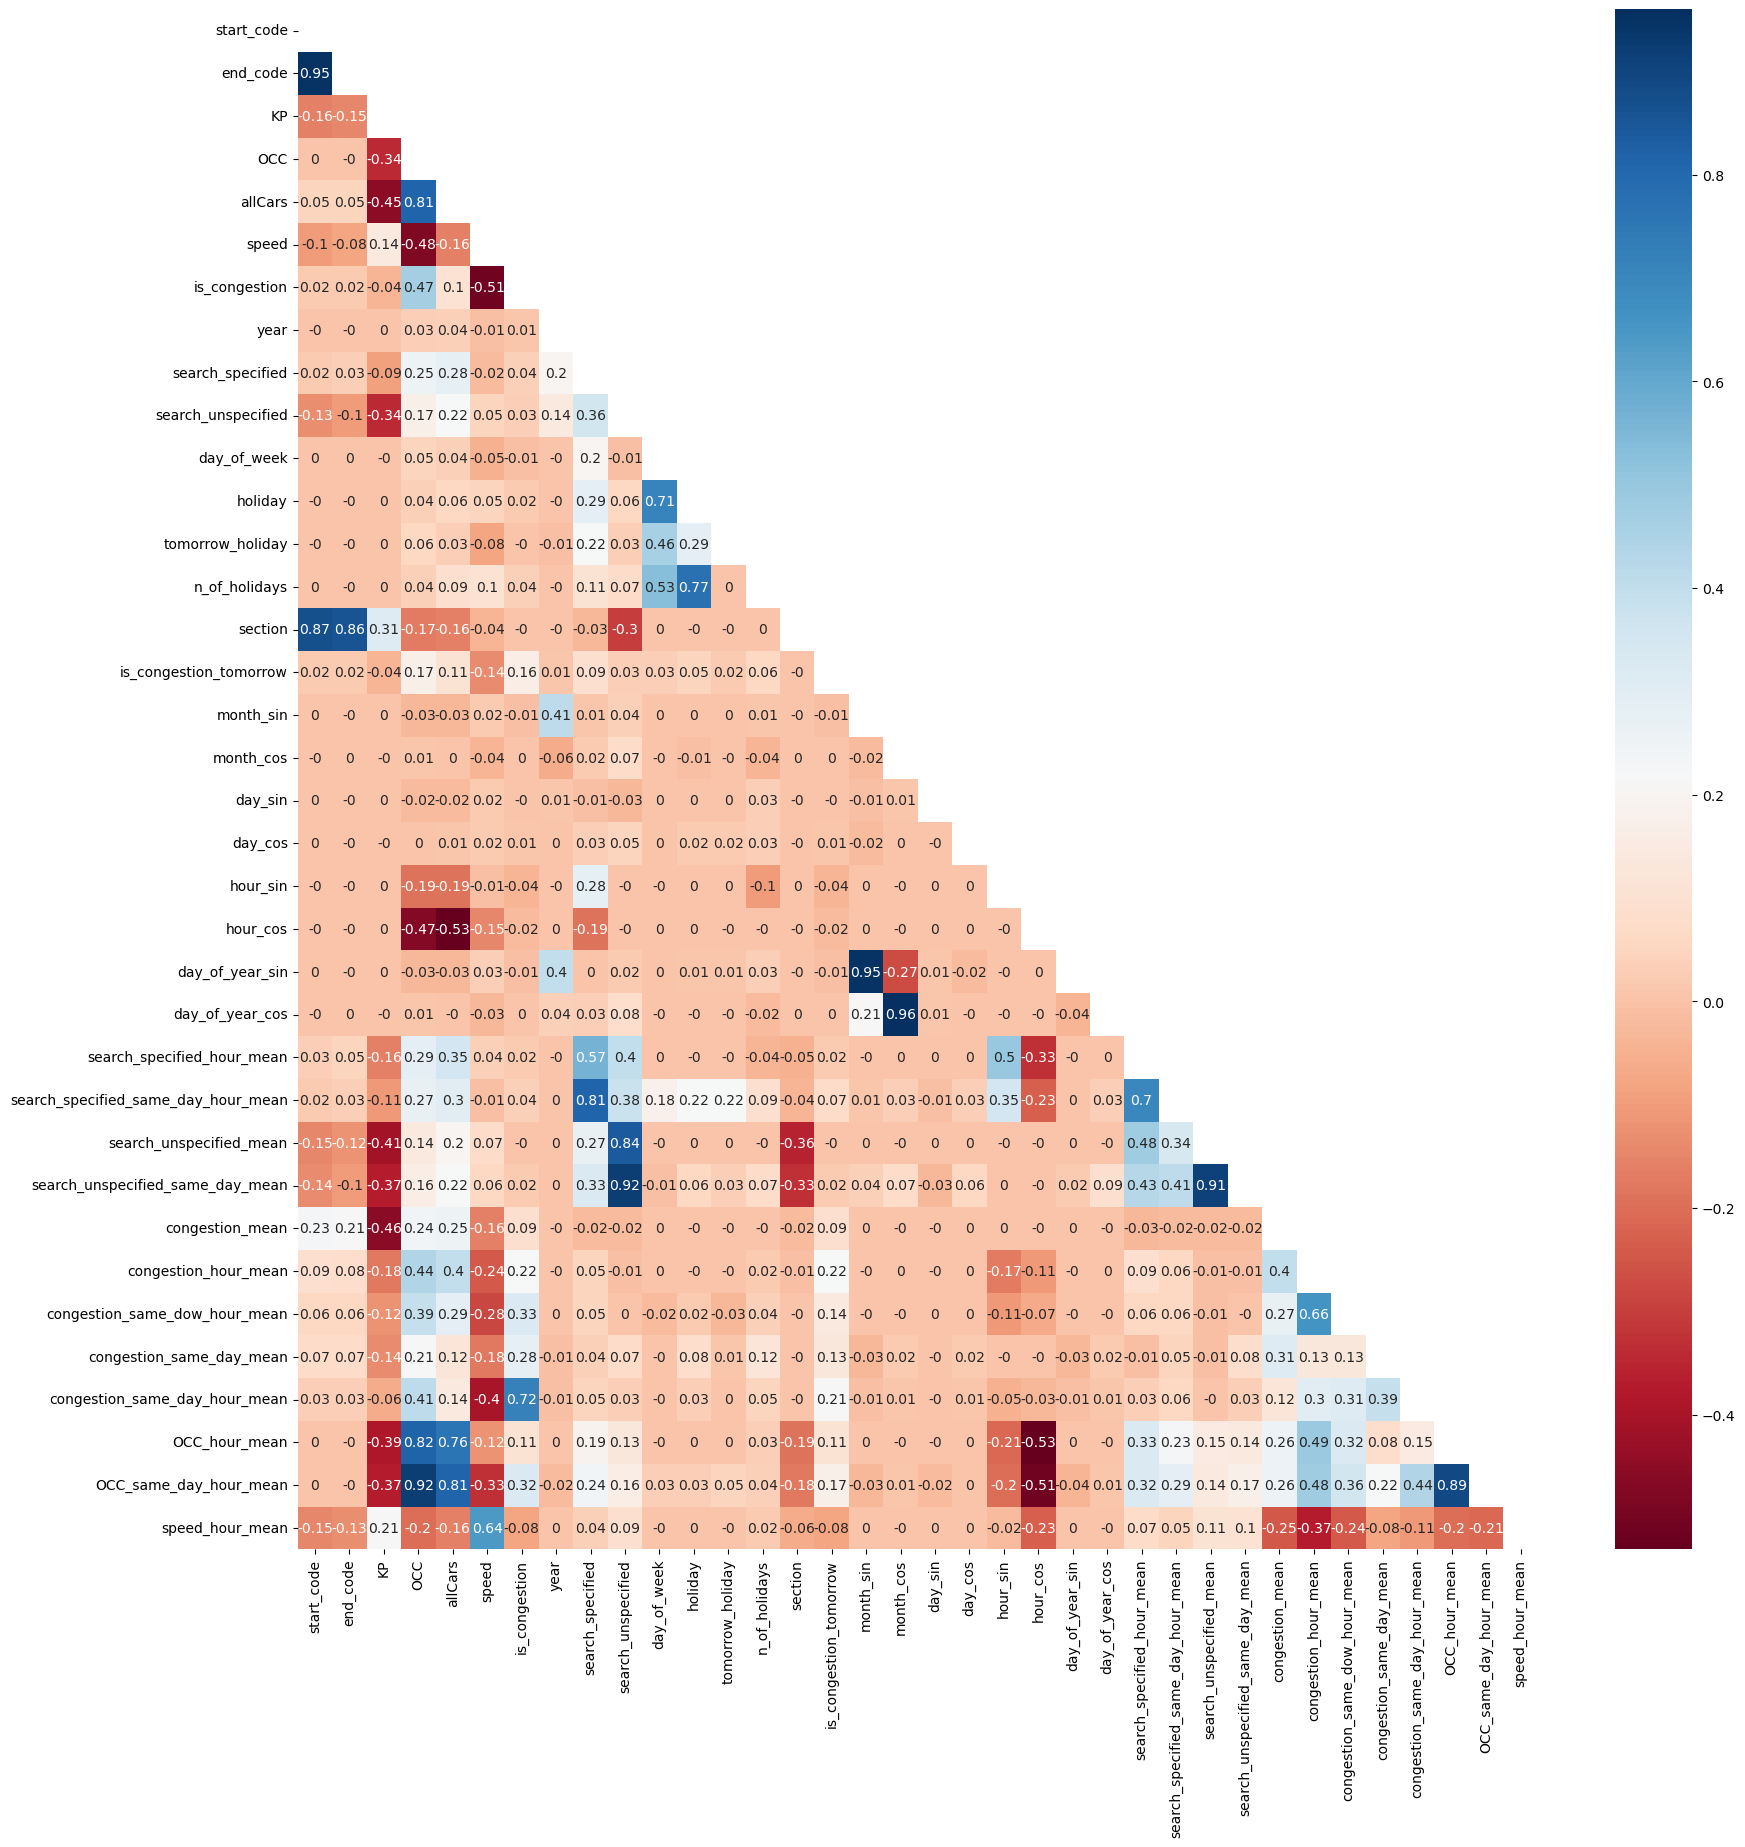

In [1465]:
%matplotlib inline

corr_df = train_merged.corr().round(2)

mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask, k=0)] = True

plt.figure(figsize=(20,20))
ax = sns.heatmap(corr_df, cmap="RdBu", annot=True, mask=mask)

plt.show()